# Transfer learning

## Imports, device setup and utility functions

In [1]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch torchvision version: {torchvision.__version__}")

device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")
print(f"Torch device: {device}")
if torch.cuda.is_available():
    for device_id in range(torch.cuda.device_count()):
        print(f"Found CUDA device: cuda:{device_id} - {torch.cuda.get_device_name(device_id)}")


PyTorch version: 2.8.0+cu126
PyTorch torchvision version: 0.23.0+cu126
Torch device: cuda
Found CUDA device: cuda:0 - Tesla T4


## Getting the base model

In [2]:
from torchvision.models import efficientnet_b0 as base_model_class, EfficientNet_B0_Weights as BaseModelWeights

base_transforms = BaseModelWeights.DEFAULT.transforms();

model = base_model_class(weights = BaseModelWeights.DEFAULT)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 88.4MB/s]


## Get the extra data

In [3]:
import requests
import zipfile
from pathlib import Path

data_path= Path("data/")
image_path= data_path / "pizza_steak_sushi"

# If the data already exists, don't download again
if image_path.is_dir():
  print(f"{image_path} directory already exists, not downloading")
else:
  print(f"{image_path} does not exist, creating")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza_steak_sushi data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating
Unzipping pizza_steak_sushi data


### Get test image

In [4]:
from PIL import Image

custom_image_path = Path("data")/"04-pizza-dad.jpg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}....")
    f.write(request.content)
else:
  print(f"Custom image already downloaded")

sample_image = Image.open(custom_image_path)

print(f"Loaded {custom_image_path}")

sample_image_transformed = base_transforms(sample_image)
print(f"Transformed image shape: {sample_image_transformed.shape}, dtype: {sample_image_transformed.dtype}")

Loaded data/04-pizza-dad.jpg
Transformed image shape: torch.Size([3, 224, 224]), dtype: torch.float32


## Show model summary using dimensions from test image

In [5]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

torchinfo.summary(model, input_size=[32,sample_image_transformed.size(dim=0),
                                       sample_image_transformed.size(dim=1),
                                       sample_image_transformed.size(dim=2)],
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## Load and transform our extra data

In [6]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

train_dir = image_path / "train"
test_dir = image_path / "test"

train_data = ImageFolder(root=train_dir,
                     transform=base_transforms
                     )
test_data = ImageFolder(root=test_dir,
                     transform=base_transforms
                     )

BATCH_SIZE = 32
SPARE_THREADS = 2

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

print(f"Loaded {len(train_data)} training samples and {len(test_data)} testing samples.")
print(f"Additional classes: {train_data.classes}")

Loaded 225 training samples and 75 testing samples.
Additional classes: ['pizza', 'steak', 'sushi']


## Freezing layers and replacing others

The summary information above shows the parameter name of the layer in the output, the feature layer is called `features`, so we can freeze all of the layers that make the `features` `Sequential` up in one hit

In [7]:
# Freeze the layers we want to keep unchanged
for layer in model.features.parameters():
  layer.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Replace the layers we want to modify.
output_shape = len(test_data.classes)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# As well as showing us a summary of the transfer model, using the real
# transformer means the tes image is of the right side and thus all our
# dimensions are checked when calling summary.
torchinfo.summary(model, input_size=[32,sample_image_transformed.size(dim=0),
                                       sample_image_transformed.size(dim=1),
                                       sample_image_transformed.size(dim=2)],
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# Train the new model!

In [11]:
try:
  import torchmetrics
except:
  !pip install torchmetrics
  import torchmetrics

utils_path = Path("utils")
if utils_path.is_dir():
  print(f"{utils_path} directory already exists, not downloading")
else:
  print(f"{utils_path} does not exist, creating")
  utils_path.mkdir(parents=True, exist_ok=True)

with open(utils_path / "engine.py", "wb") as f:
  request = requests.get("https://github.com/Endolf/pytorch-deep-learning-rocm/raw/refs/heads/main/src/going_modular/engine.py")
  print("Downloading engine.py")
  f.write(request.content)

with open(utils_path / "utils.py", "wb") as f:
  request = requests.get("https://github.com/Endolf/pytorch-deep-learning-rocm/raw/refs/heads/main/src/going_modular/utils.py")
  print("Downloading utils.py")
  f.write(request.content)

from utils import engine
from utils.utils import plot_loss_curves, prep_and_plot_confusion_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.4 MB/s eta 0:00:00
utils directory already exists, not downloading


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561


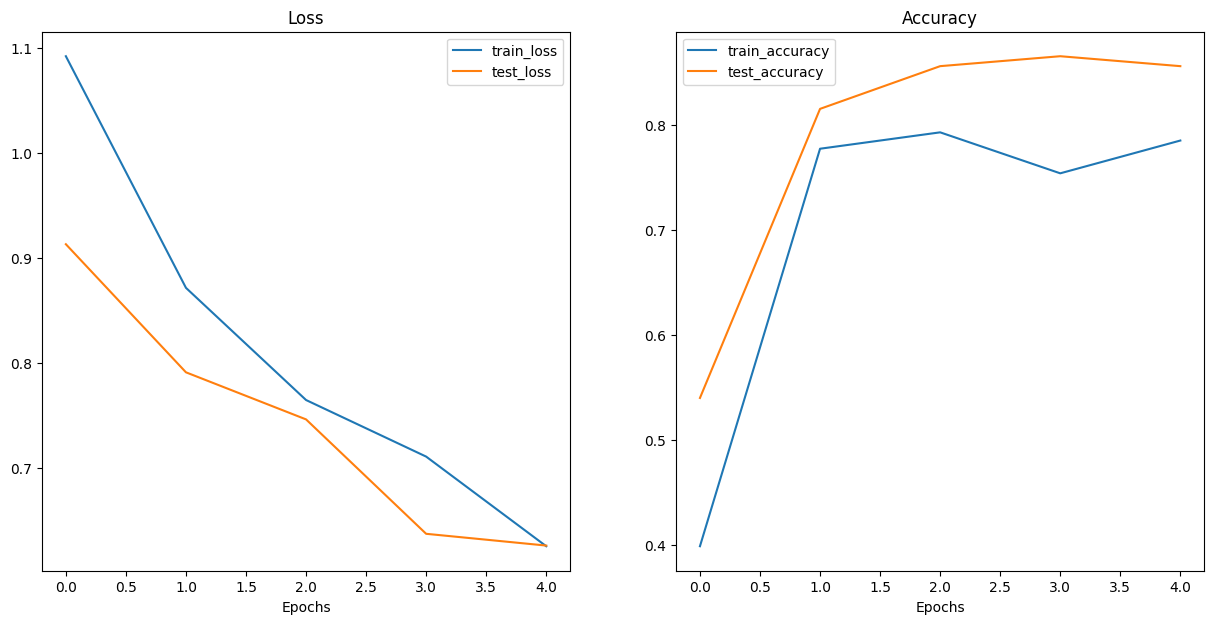

Making predictions...:   0%|          | 0/3 [00:00<?, ?it/s]

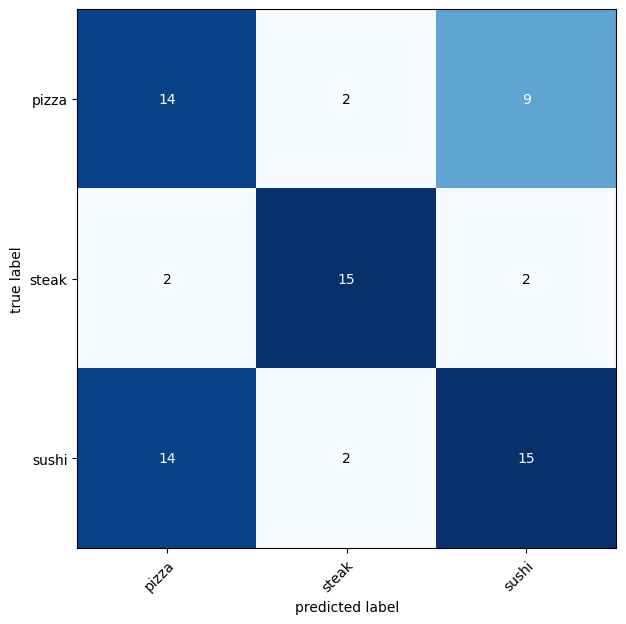

In [12]:
from torch import nn
from timeit import default_timer as timer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
end_time = timer()

plot_loss_curves(results)

prep_and_plot_confusion_matrix(model, test_data, test_dataloader, device)

Custom image already downloaded
Loaded data/04-pizza-dad.jpg
Transformed image to torch.Size([3, 224, 224]) of type torch.float32


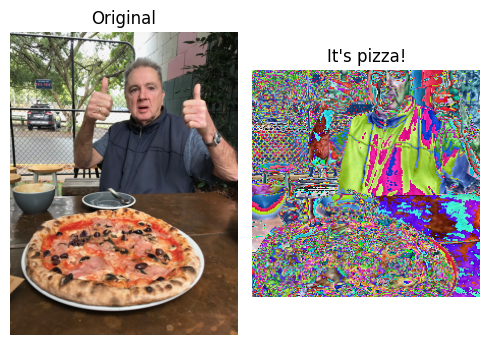

In [22]:
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms

custom_image_path = data_path/"04-pizza-dad.jpg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}....")
    f.write(request.content)
else:
  print(f"Custom image already downloaded")

# We can't use torchvision on jpegs as the rocm version isn't compiled with
# jpeg support
# custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image = Image.open(custom_image_path)

print(f"Loaded {custom_image_path}")# as {custom_image_uint8.shape} of type {custom_image_uint8.dtype}")

# Run it through the simple transform to set the data shape and dtype.
custom_image_transformed = base_transforms(custom_image).to(device)
print(f"Transformed image to {custom_image_transformed.shape} of type {custom_image_transformed.dtype}")

model.eval()
with torch.inference_mode() :
  y_pred = model(custom_image_transformed.unsqueeze(dim=0))
  y_label = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
  y_label_text = test_data.classes[y_label]

fig = plt.figure(figsize=(5,7))
plt.subplot(1,2,1)
plt.imshow(custom_image)
plt.axis(False)
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(transforms.ToPILImage()(custom_image_transformed))
plt.axis(False)
plt.title(f"It's {y_label_text}!")
fig.tight_layout()
fig.show()